In [1]:
### Week 7-2: Feature Selection Lab

## Import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

## Import data
df = pd.read_csv("OnlineNews.csv")

## Data pre-processing
# Drop irrelevant variables
df.drop(labels=['url', 'timedelta'], axis = 1, inplace=True)

# Categorize share
share_df = df["shares"]
share_df.describe()

/Users/chpyo/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64

In [2]:
percent = np.array([25,50,75,90])
for i in percent:    
    print('Top', 100-i,'%:',np.percentile(share_df, i))
    
share_label = list()
for shares in share_df:
    if shares <= 946:
        share_label.append('Very Poor')
    elif shares > 946 and shares <= 1400:
        share_label.append('Poor')
    elif shares > 1400 and shares <= 2800:
        share_label.append('Average')
    elif shares > 2800 and shares <= 6200:
        share_label.append('Good')
    elif shares > 6200:
        share_label.append('Very Good')

df = pd.concat([df, pd.DataFrame(share_label, columns=['popularity'])], axis=1)
df['popularity']=df['popularity'].astype('category')

Top 75 %: 946.0
Top 50 %: 1400.0
Top 25 %: 2800.0
Top 10 %: 6200.0


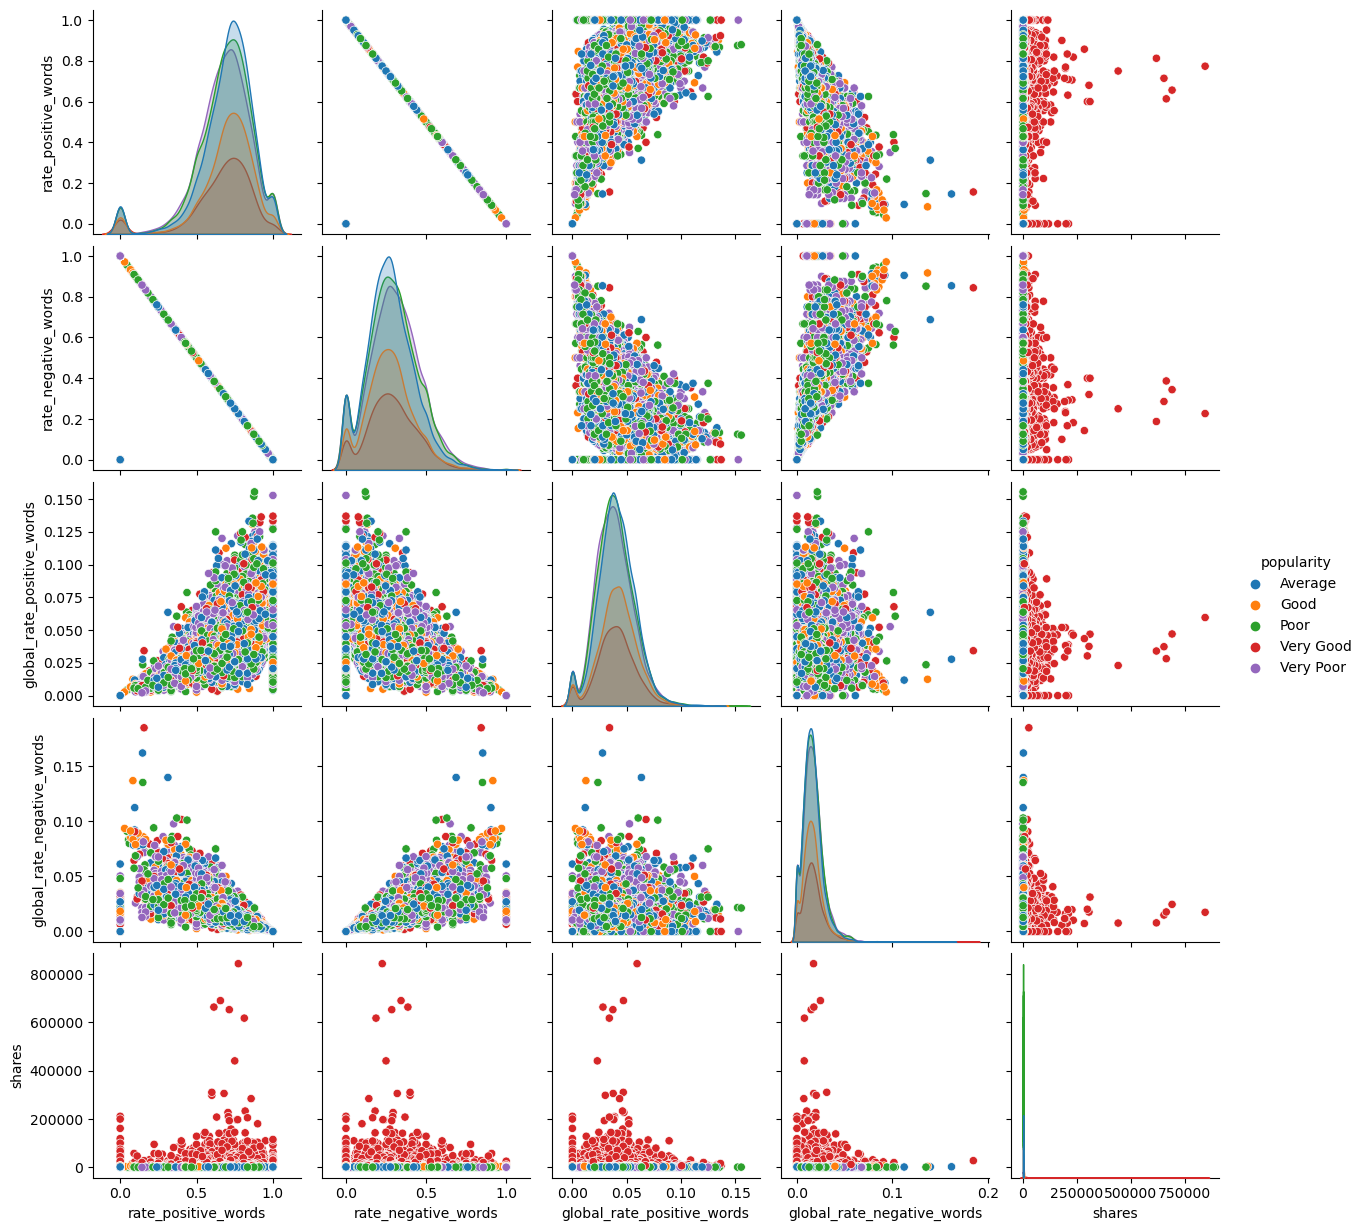

In [3]:
# Transform popularity to a categorical variable with labels
from sklearn.preprocessing import LabelEncoder
labelEn = LabelEncoder()
encoded_labels = labelEn.fit_transform(df.loc[:, 'popularity'].values)

## Some visualization for exploratory purpose
# Sentiment and popularity
kw_cols = ['rate_positive_words', 'rate_negative_words', 'global_rate_positive_words', 'global_rate_negative_words', 'shares']
sns.pairplot(df, vars=kw_cols, hue='popularity', diag_kind='kde')

In [4]:
# Article category and popularity
ax = sns.catplot(x='data_channel', col="popularity", data=df, kind="count", height=8, aspect=.7)

# Article length and popularity
sns.scatterplot(x='n_tokens_content',y='popularity', data=df)

<AxesSubplot:title={'center':'popularity = Very Poor'}, xlabel='data_channel', ylabel='popularity'>

In [5]:
## KNN without Feature Selection
# Construct variables
X = df.iloc[:,:44]
y = df['popularity']

X_dummy = pd.get_dummies(X, columns=['weekdays','data_channel'])

# Standardize predictors
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_std = scaler.fit_transform(X_dummy)
X_std=pd.DataFrame(X_std, columns=X_dummy.columns)

In [6]:
# GridsearchCV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
parameters = {'n_neighbors':[50,75,100,125,150,175,200,225,250,275,300,325,350],
              'weights': ['uniform', 'distance']}

knn = KNeighborsClassifier(p=2)
model = GridSearchCV(knn, parameters, cv=5)
model.fit(X_std,y)
model.best_params_ #n_neighbors: 250; weights: distance

{'n_neighbors': 250, 'weights': 'distance'}

In [7]:
# Build KNN and evaluate accuracy
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.3, random_state = 0)

knn = KNeighborsClassifier(n_neighbors=250, p=2, weights='distance')
model = knn.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_knn = accuracy_score(y_test, y_test_pred)

/var/folders/fj/r58mc2p16y97yyqcvtrpm6240000gn/T/ipykernel_94396/200779622.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(X_std.columns[tree_importance_sorted_idx])


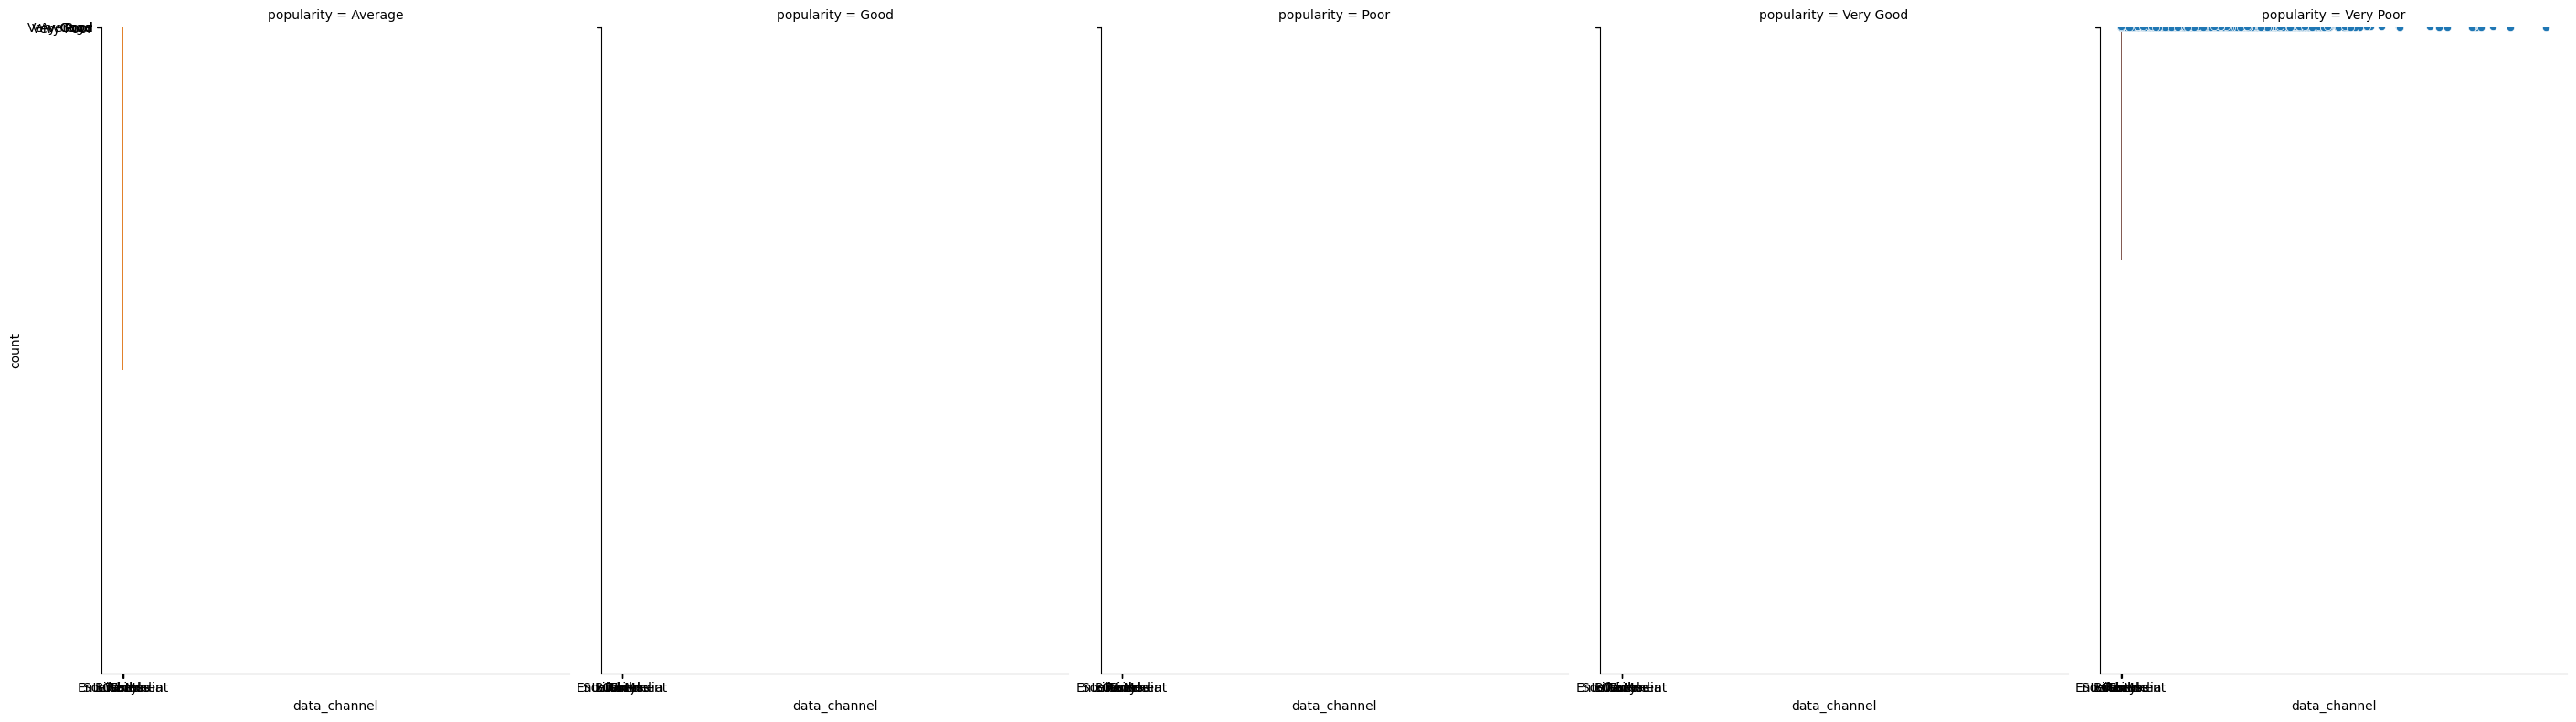

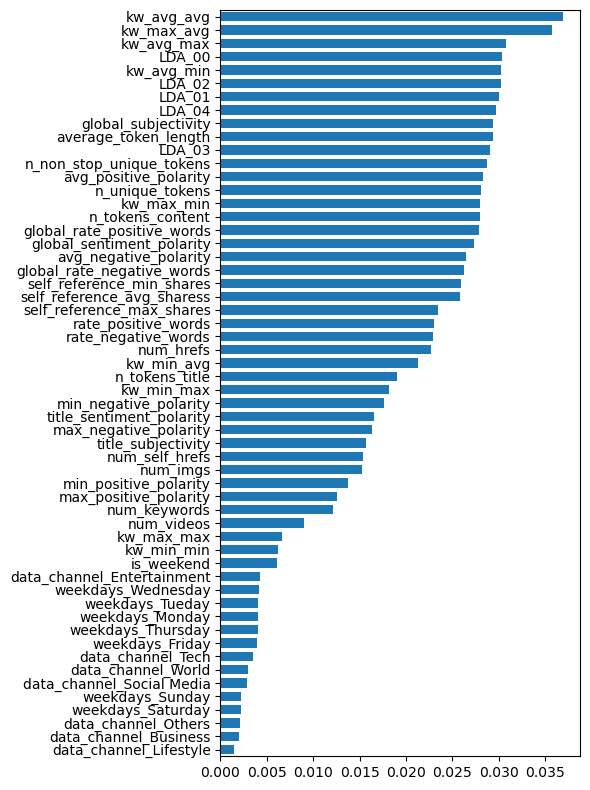

In [8]:
## KNN with top 10 features selected from Random Forest
# Feature selection using Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
model = rf.fit(X_std, y)

# Visualize feature importance 
from sklearn.inspection import permutation_importance
result = permutation_importance(rf, X_std, y, n_repeats=1,
                                random_state=0)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(rf.feature_importances_)
tree_indices = np.arange(0, len(rf.feature_importances_)) + 0.5

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 8))
ax1.barh(tree_indices,
         rf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(X_std.columns[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(rf.feature_importances_)))

fig.tight_layout()
plt.show()

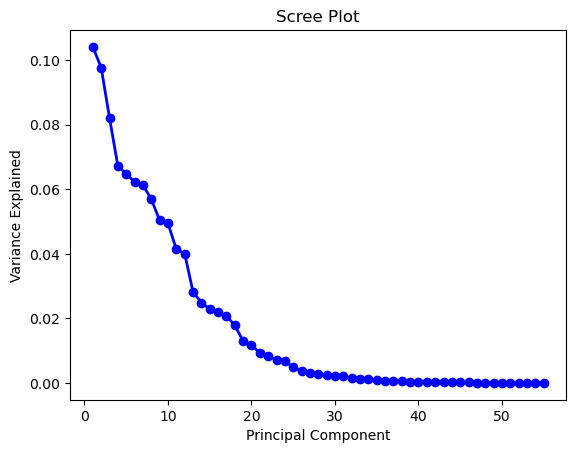

In [9]:
# Build KNN with selected features
X_new = X_std[['kw_avg_avg', 'kw_max_avg', 'kw_avg_max', 'LDA_00', 'kw_avg_min', 'LDA_02', 'LDA_01', 'LDA_04', 'global_subjectivity','average_token_length']]
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.3, random_state = 0)

knn = KNeighborsClassifier(n_neighbors=250, p=2, weights='distance')
model = knn.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
accuracy_knn_rf = accuracy_score(y_test, y_test_pred)

## KNN with PCA
# Run PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=55)
pca.fit(X_std)

# Using elbow method to select number of components
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [10]:
# Build KNN with 25 components
pca = PCA(n_components=25)
pca.fit(X_std)
X_new_pca = pca.transform(X_std)

X_train, X_test, y_train, y_test = train_test_split(X_new_pca, y, test_size = 0.3, random_state = 0)

knn = KNeighborsClassifier(n_neighbors=250, p=2, weights='distance')
model = knn.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
accuracy_knn_pca = accuracy_score(y_test, y_test_pred)